## Image Denoising

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np


In [28]:
# Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=1, padding=0),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=1, padding=0)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Gaussian noise
def add_gaussian_noise(images, mean=0., std=0.1):
    noisy_images = images + torch.randn_like(images) * std
    noisy_images = torch.clamp(noisy_images, -1., 1.)
    return noisy_images

# CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Model setup
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Files already downloaded and verified
Files already downloaded and verified


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
  )
)

Epoch 1, Loss: 0.039998179830401145
Epoch 2, Loss: 0.015444130802293643
Epoch 3, Loss: 0.012366236987835764
Epoch 4, Loss: 0.010939602806802144
Epoch 5, Loss: 0.010211440864378763
Epoch 6, Loss: 0.009655940584609729
Epoch 7, Loss: 0.009331026827902211
Epoch 8, Loss: 0.009076864260327442
Epoch 9, Loss: 0.008926708873509027
Epoch 10, Loss: 0.008723065350561991


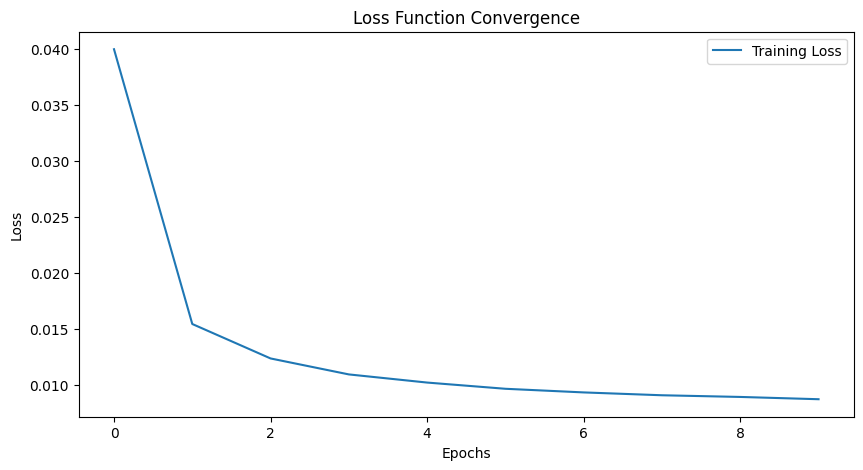

In [29]:
# Training loop
epoch_losses = []
for epoch in range(10):  # Assuming 10 epochs
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        noisy_inputs = add_gaussian_noise(inputs).to(device) # Adding noise to the input
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

# Plotting the loss function
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Loss Function Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


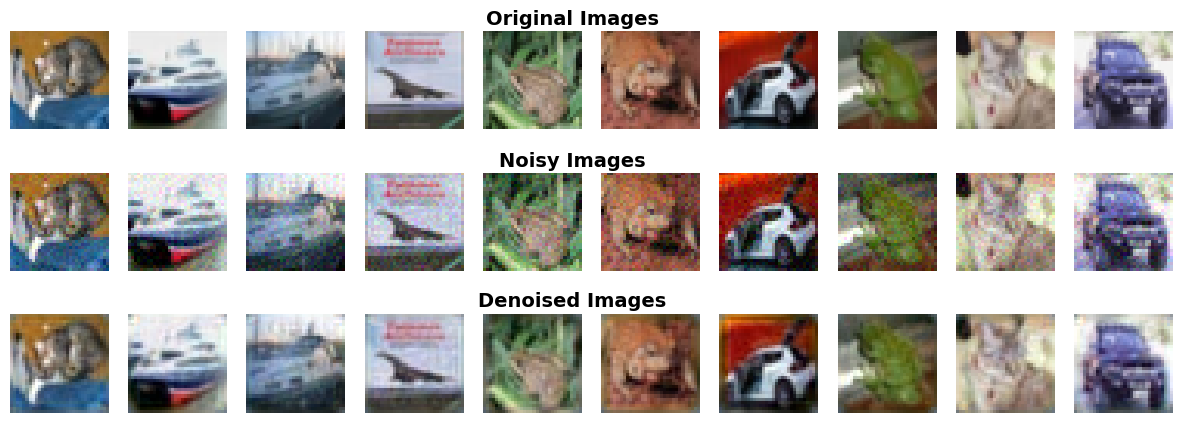

Mean PSNR: 27.094648515268524
Mean SSIM: 0.9219057559967041


In [42]:
def tensor_to_numpy(image_tensor):
    # Convert tensor image to numpy array and scale it to [0, 1] range
    return image_tensor.detach().cpu().numpy().transpose((1, 2, 0)) / 2.0 + 0.5

# Testing the model and visualizing the denoising results
model.eval()
with torch.no_grad():
    dataiter = iter(testloader)
    images, _ = next(dataiter)
    noisy_images = add_gaussian_noise(images)
    denoised_images = model(noisy_images.to(device)).cpu()

    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    plt.subplots_adjust(hspace=0.4)  # Adjust horizontal space to accommodate titles
    
    # Adding row titles using text annotations
    fig.text(0.5, 0.9, 'Original Images', ha='center', va='center', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.616, 'Noisy Images', ha='center', va='center', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.335, 'Denoised Images', ha='center', va='center', fontsize=14, fontweight='bold')
    
    for i in range(10):
        # Original images
        axes[0, i].imshow(tensor_to_numpy(images[i]))
        axes[0, i].axis('off')
        
        # Noisy images
        axes[1, i].imshow(tensor_to_numpy(noisy_images[i]))
        axes[1, i].axis('off')
        
        # Denoised images
        axes[2, i].imshow(tensor_to_numpy(denoised_images[i]))
        axes[2, i].axis('off')

    plt.show()

    # Calculate and report PSNR and SSIM
    psnrs = []
    ssims = []
    for data in testloader:
        clean_images, _ = data
        noisy_images = add_gaussian_noise(clean_images)
        denoised_images = model(noisy_images.to(device)).cpu()

        # Loop through the batch
        for i in range(clean_images.size(0)):
            clean_image_np = tensor_to_numpy(clean_images[i])
            denoised_image_np = tensor_to_numpy(denoised_images[i])

            psnr = compare_psnr(clean_image_np, denoised_image_np, data_range=1)
            ssim = compare_ssim(clean_image_np, denoised_image_np, data_range=1, multichannel=True, channel_axis=2)
            psnrs.append(psnr)
            ssims.append(ssim)
    
    # Calculate mean PSNR and SSIM
    mean_psnr = np.mean(psnrs)
    mean_ssim = np.mean(ssims)
    print(f'Mean PSNR: {mean_psnr}')
    print(f'Mean SSIM: {mean_ssim}')
